# Environment

Pin the versions once so the comparison plots are reproducible.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!python --version

Python 3.12.12


In [8]:
!pip install -q transformers==4.45.0 torch torchvision pillow accelerate scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 115.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 108.2 MB/s eta 0:00:00


In [9]:
import os
import json
import time
import torch
from PIL import Image
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from sklearn.metrics import precision_recall_fscore_support

print(f"PyTorch: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch: 2.9.0+cu126
CUDA Available: True
GPU: NVIDIA A100-SXM4-40GB


# Data configuration

Point the helper to the RecipeQA splits we exported earlier.

In [3]:
# Data paths
DATA_DIR = "/content/drive/MyDrive/GenAI Project/recipeqa"
VAL_JSON = os.path.join(DATA_DIR, "recipeqa_val.json")
VAL_IMAGES = os.path.join(DATA_DIR, "val")

# Results directory
RESULTS_DIR = "/content/drive/MyDrive/GenAI Project/recipeqa/results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Load validation data
with open(VAL_JSON, 'r') as f:
    val_data = json.load(f)

print(f"Validation samples: {len(val_data)}")
print(f"\nExample sample:")
print(json.dumps(val_data[0], indent=2))

Validation samples: 80

Example sample:
{
  "id": "recipeqa_51_0",
  "image": "51_0_false.jpg",
  "conversations": [
    {
      "from": "human",
      "value": "<image>\nIdentify if from left to right is the correct order of cooking this how to make mini pizzas margaritas. Answer only 'true' or 'false'."
    },
    {
      "from": "gpt",
      "value": "false"
    }
  ]
}


# Model 1: LLaVA v1.5-7B (zero-shot)

Run the released weights directly to get a baseline before any of our tweaks.

In [ ]:
# Load LLaVA v1.5
from transformers import AutoProcessor, LlavaForConditionalGeneration

print("Loading LLaVA v1.5-7B...")
llava_model_id = "llava-hf/llava-1.5-7b-hf"

llava_processor = AutoProcessor.from_pretrained(llava_model_id)

llava_model = LlavaForConditionalGeneration.from_pretrained(
    llava_model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to('cuda')

print(f"  Model loaded on {llava_model.device}")
print(f"  Model dtype: {llava_model.dtype}")

Loading LLaVA v1.5-7B...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✓ Model loaded on cuda:0
✓ Model dtype: torch.float16


TESTING WITH SINGLE SAMPLE

Sample ID: recipeqa_51_0
Image: 51_0_false.jpg
Question: <image>
Identify if from left to right is the correct order of cooking this how to make mini pizzas margaritas. Answer only 'true' or 'false'.
Ground Truth: false


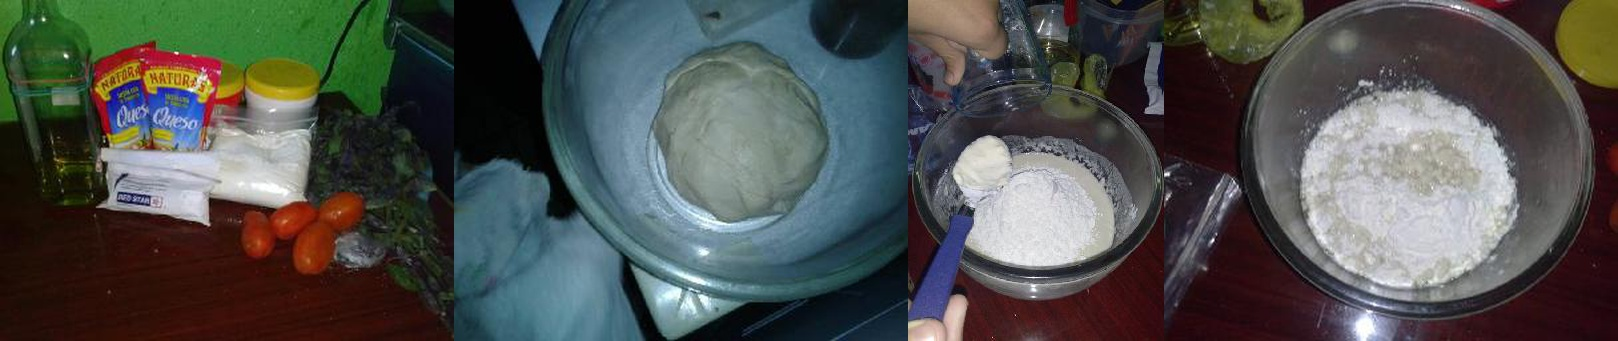


Prompt:
USER: <image>
Identify if from left to right is the correct order of cooking this how to make mini pizzas margaritas. Answer only 'true' or 'false'.
ASSISTANT:

Input IDs shape: torch.Size([1, 623])
Pixel values shape: torch.Size([1, 3, 336, 336])

Generating...


Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Output IDs shape: torch.Size([1, 625])
Output IDs: tensor([    1,  3148,  1001, 29901, 29871, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000,
        32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000, 32000],
       device='cuda:0')...

--- FULL OUTPUT ---
USER:  
Identify if from left to right is the correct order of cooking this how to make mini pizzas margaritas. Answer only 'true' or 'false'.
ASSISTANT: True
--- END OUTPUT ---

Extracted answer: 'True'



In [6]:
# Test with a single sample first
print("="*60)
print("TESTING WITH SINGLE SAMPLE")
print("="*60)

test_sample = val_data[0]
test_image_path = os.path.join(VAL_IMAGES, test_sample['image'])
test_image = Image.open(test_image_path).convert('RGB')
test_question = test_sample['conversations'][0]['value']
test_ground_truth = test_sample['conversations'][1]['value']

print(f"\nSample ID: {test_sample['id']}")
print(f"Image: {test_sample['image']}")
print(f"Question: {test_question}")
print(f"Ground Truth: {test_ground_truth}")

# Display image
from IPython.display import display
display(test_image)

# Prepare prompt - DON'T include <image> manually, processor adds it
test_prompt = f"USER: {test_question}\nASSISTANT:"
print(f"\nPrompt:\n{test_prompt}")

# Process
test_inputs = llava_processor(text=test_prompt, images=test_image, return_tensors="pt")

# Move to device
test_input_ids = test_inputs['input_ids'].to(llava_model.device)
test_pixel_values = test_inputs['pixel_values'].to(llava_model.device, dtype=llava_model.dtype)
test_attention_mask = test_inputs.get('attention_mask')
if test_attention_mask is not None:
    test_attention_mask = test_attention_mask.to(llava_model.device)

print(f"\nInput IDs shape: {test_input_ids.shape}")
print(f"Pixel values shape: {test_pixel_values.shape}")

# Generate
print("\nGenerating...")
with torch.no_grad():
    test_output_ids = llava_model.generate(
        input_ids=test_input_ids,
        pixel_values=test_pixel_values,
        attention_mask=test_attention_mask,
        max_new_tokens=32,
        do_sample=False,
        num_beams=1,
        use_cache=True
    )

print(f"Output IDs shape: {test_output_ids.shape}")
print(f"Output IDs: {test_output_ids[0][:50]}...")  # First 50 tokens

# Decode
try:
    test_full_output = llava_processor.tokenizer.decode(test_output_ids[0], skip_special_tokens=True)
    print(f"\n--- FULL OUTPUT ---")
    print(test_full_output)
    print(f"--- END OUTPUT ---")

    # Extract answer
    if "ASSISTANT:" in test_full_output:
        test_answer = test_full_output.split("ASSISTANT:")[-1].strip()
        print(f"\nExtracted answer: '{test_answer}'")
    else:
        print(f"\nNo ASSISTANT: found, using full output: '{test_full_output}'")

except Exception as e:
    print(f"\nDecode error: {e}")
    import traceback
    traceback.print_exc()

print("\n" + "="*60)

In [ ]:
def evaluate_llava_v15(model, processor, data, image_folder, max_samples=None):
    """
    Evaluate LLaVA v1.5 on RecipeQA validation set with optimizations
    """
    results = []
    correct = 0
    total = 0

    # Ensure model is in eval mode
    model.eval()

    # Limit samples if specified
    eval_data = data[:max_samples] if max_samples else data

    # Track timing
    start_time = time.time()

    for idx, sample in enumerate(tqdm(eval_data, desc="Evaluating LLaVA v1.5")):
        sample_id = sample['id']
        image_name = sample['image']
        question = sample['conversations'][0]['value']
        ground_truth = sample['conversations'][1]['value'].strip().lower()

        # Load image
        image_path = os.path.join(image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"Warning: Image not found: {image_path}")
            continue

        try:
            image = Image.open(image_path).convert('RGB')

            # Prepare prompt - processor adds <image> automatically
            prompt = f"USER: {question}\nASSISTANT:"

            # Process inputs
            inputs = processor(text=prompt, images=image, return_tensors="pt")

            # Move to device
            input_ids = inputs['input_ids'].to(model.device)
            pixel_values = inputs['pixel_values'].to(model.device, dtype=model.dtype)
            attention_mask = inputs.get('attention_mask')
            if attention_mask is not None:
                attention_mask = attention_mask.to(model.device)

            # Generate with optimizations
            with torch.no_grad():
                with torch.amp.autocast('cuda'):  # Mixed precision for speed
                    output_ids = model.generate(
                        input_ids=input_ids,
                        pixel_values=pixel_values,
                        attention_mask=attention_mask,
                        max_new_tokens=10,  # Reduced - we only need "true" or "false"
                        do_sample=False,
                        num_beams=1,
                        use_cache=True
                    )

            # Decode
            full_output = processor.tokenizer.decode(output_ids[0], skip_special_tokens=True)

            # Extract the generated part
            if "ASSISTANT:" in full_output:
                output_text = full_output.split("ASSISTANT:")[-1].strip().lower()
            else:
                output_text = full_output.strip().lower()

            # Extract true/false from prediction
            if "true" in output_text and "false" not in output_text:
                predicted_answer = "true"
            elif "false" in output_text:
                predicted_answer = "false"
            else:
                predicted_answer = "unknown"

            # Check correctness
            is_correct = (predicted_answer == ground_truth)

            if is_correct:
                correct += 1
            total += 1

            # Store result
            results.append({
                'id': sample_id,
                'image': image_name,
                'question': question,
                'ground_truth': ground_truth,
                'prediction': predicted_answer,
                'full_output': output_text,
                'correct': is_correct
            })

            # Print timing every 10 samples
            if (idx + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (idx + 1)
                remaining = avg_time * (len(eval_data) - idx - 1)
                print(f"\n[{idx + 1}/{len(eval_data)}] Avg: {avg_time:.1f}s/sample | ETA: {remaining/60:.1f}min")

        except Exception as e:
            print(f"\nError processing sample {sample_id}: {str(e)}")
            results.append({
                'id': sample_id,
                'image': image_name,
                'question': question,
                'ground_truth': ground_truth,
                'prediction': 'error',
                'full_output': f"Error: {str(e)}",
                'correct': False
            })
            continue

    total_time = time.time() - start_time
    print(f"\n  Total time: {total_time/60:.1f} minutes")
    print(f"  Average time per sample: {total_time/len(eval_data):.1f} seconds")

    accuracy = correct / total if total > 0 else 0
    return results, accuracy

In [ ]:
# Evaluate LLaVA v1.5
print("\n" + "="*60)
print("Evaluating LLaVA v1.5-7B (Zero-Shot)")
print("="*60)

llava_v15_results, llava_v15_accuracy = evaluate_llava_v15(
    llava_model,
    llava_processor,
    val_data,
    VAL_IMAGES,
    max_samples=None  # Set to a number to test on fewer samples
)

print(f"\n{'='*60}")
print(f"LLaVA v1.5 Results:")
print(f"{'='*60}")
print(f"Accuracy: {llava_v15_accuracy:.2%} ({sum(r['correct'] for r in llava_v15_results)}/{len(llava_v15_results)})")
print(f"{'='*60}\n")

# Generate timestamp for file naming
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
llava_v15_results_file = os.path.join(RESULTS_DIR, f"llava_v15_results_{timestamp}.json")

# Clean up GPU memory
del llava_model
del llava_processor
print("  Model cleaned up from memory")


Evaluating LLaVA v1.5-7B (Zero-Shot)


Evaluating LLaVA v1.5:  14%|█▍        | 11/80 [00:01<00:09,  7.51it/s]


[10/80] Avg: 0.1s/sample | ETA: 0.2min


Evaluating LLaVA v1.5:  26%|██▋       | 21/80 [00:02<00:07,  7.41it/s]


[20/80] Avg: 0.1s/sample | ETA: 0.1min


Evaluating LLaVA v1.5:  39%|███▉      | 31/80 [00:04<00:06,  7.47it/s]


[30/80] Avg: 0.1s/sample | ETA: 0.1min


Evaluating LLaVA v1.5:  51%|█████▏    | 41/80 [00:05<00:05,  7.50it/s]


[40/80] Avg: 0.1s/sample | ETA: 0.1min


Evaluating LLaVA v1.5:  64%|██████▍   | 51/80 [00:06<00:03,  7.39it/s]


[50/80] Avg: 0.1s/sample | ETA: 0.1min


Evaluating LLaVA v1.5:  76%|███████▋  | 61/80 [00:08<00:02,  7.20it/s]


[60/80] Avg: 0.1s/sample | ETA: 0.0min


Evaluating LLaVA v1.5:  89%|████████▉ | 71/80 [00:09<00:01,  7.57it/s]


[70/80] Avg: 0.1s/sample | ETA: 0.0min


Evaluating LLaVA v1.5: 100%|██████████| 80/80 [00:10<00:00,  7.44it/s]


[80/80] Avg: 0.1s/sample | ETA: 0.0min

✓ Total time: 0.2 minutes
✓ Average time per sample: 0.1 seconds

LLaVA v1.5 Results:
Accuracy: 25.00% (20/80)

✓ Model cleaned up from memory


# LLaVA-Next sanity check

Quick run with the Next weights just to see if the newer recipe helps.

In [ ]:
# Load LLaVA-NeXT
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

print("Loading LLaVA-NeXT-7B...")
llava_next_model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

llava_next_processor = LlavaNextProcessor.from_pretrained(llava_next_model_id)

# Load model and explicitly move to CUDA
llava_next_model = LlavaNextForConditionalGeneration.from_pretrained(
    llava_next_model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to('cuda')

print(f"  Model loaded on {llava_next_model.device}")
print(f"  Model dtype: {llava_next_model.dtype}")

Loading LLaVA-NeXT-7B...


Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded on cuda:0
✓ Model dtype: torch.float16


In [ ]:
# Load LLaVA-NeXT
from transformers import LlavaNextProcessor, LlavaNextForConditionalGeneration

print("Loading LLaVA-NeXT-7B...")
llava_next_model_id = "llava-hf/llava-v1.6-mistral-7b-hf"

llava_next_processor = LlavaNextProcessor.from_pretrained(llava_next_model_id)

# Load model and explicitly move to CUDA
llava_next_model = LlavaNextForConditionalGeneration.from_pretrained(
    llava_next_model_id,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to('cuda')

print(f"  Model loaded on {llava_next_model.device}")
print(f"  Model dtype: {llava_next_model.dtype}")

# Test with one image
print("\n" + "="*60)
print("TESTING WITH ONE IMAGE")
print("="*60)

test_sample = val_data[0]
test_image_path = os.path.join(VAL_IMAGES, test_sample['image'])
test_question = test_sample['conversations'][0]['value']

print(f"Sample ID: {test_sample['id']}")
print(f"Image: {test_sample['image']}")
print(f"Question (raw): {test_question}")
print(f"Ground truth: {test_sample['conversations'][1]['value']}")

try:
    test_image = Image.open(test_image_path).convert('RGB')
    print(f"  Image loaded: {test_image.size}")

    # Remove <image> from question if present (it's already in the data)
    test_question_clean = test_question.replace('<image>', '').replace('\n\n', '\n').strip()

    # Create prompt - LLaVA-NeXT format
    test_prompt = f"[INST] <image>\n{test_question_clean} [/INST]"
    print(f"\nCleaned question: {test_question_clean[:80]}...")
    print(f"Final prompt: {test_prompt[:100]}...")

    # Process
    print("\nProcessing inputs...")
    test_inputs = llava_next_processor(text=test_prompt, images=test_image, return_tensors="pt", padding=True)

    print(f"Input IDs shape: {test_inputs['input_ids'].shape}")
    print(f"Pixel values shape: {test_inputs['pixel_values'].shape}")
    print(f"Keys in inputs: {test_inputs.keys()}")

    # Move to GPU
    test_input_ids = test_inputs['input_ids'].to('cuda')
    test_pixel_values = test_inputs['pixel_values'].to('cuda', dtype=torch.float16)
    test_attention_mask = test_inputs.get('attention_mask')
    if test_attention_mask is not None:
        test_attention_mask = test_attention_mask.to('cuda')

    # Handle image_sizes - CRITICAL for LLaVA-NeXT
    test_image_sizes = test_inputs.get('image_sizes')
    if test_image_sizes is not None:
        test_image_sizes = test_image_sizes.to('cuda')
        print(f"  Image sizes: {test_image_sizes}")
    else:
        print("No image_sizes in inputs!")

    print("\n  All inputs moved to GPU")

    # Generate
    print("\nGenerating...")
    gen_kwargs = {
        'input_ids': test_input_ids,
        'pixel_values': test_pixel_values,
        'attention_mask': test_attention_mask,
        'max_new_tokens': 10,
        'do_sample': False,
        'num_beams': 1,
        'use_cache': True
    }

    # Add image_sizes if available
    if test_image_sizes is not None:
        gen_kwargs['image_sizes'] = test_image_sizes

    with torch.no_grad():
        test_output_ids = llava_next_model.generate(**gen_kwargs)

    print(f"Output shape: {test_output_ids.shape}")

    # Decode
    test_generated_ids = test_output_ids[0][test_input_ids.shape[1]:]
    test_output = llava_next_processor.decode(test_generated_ids, skip_special_tokens=True).strip()

    print(f"\n{'='*60}")
    print(f"OUTPUT: {test_output}")
    print(f"{'='*60}")

except Exception as e:
    import traceback
    print(f"\nERROR: {str(e)}")
    print(traceback.format_exc())

Loading LLaVA-NeXT-7B...


Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


✓ Model loaded on cuda:0
✓ Model dtype: torch.float16

TESTING WITH ONE IMAGE
Sample ID: recipeqa_51_0
Image: 51_0_false.jpg
Question (raw): <image>
Identify if from left to right is the correct order of cooking this how to make mini pizzas margaritas. Answer only 'true' or 'false'.
Ground truth: false
✓ Image loaded: (1618, 341)

Cleaned question: Identify if from left to right is the correct order of cooking this how to make ...
Final prompt: [INST] <image>
Identify if from left to right is the correct order of cooking this how to make mini ...

Processing inputs...
✓ Input IDs shape: torch.Size([1, 1789])
✓ Pixel values shape: torch.Size([1, 4, 3, 336, 336])
Keys in inputs: dict_keys(['input_ids', 'attention_mask', 'pixel_values', 'image_sizes'])
✓ Image sizes: tensor([[ 341, 1618]], device='cuda:0')

✓ All inputs moved to GPU

Generating...
✓ Output shape: torch.Size([1, 1799])

OUTPUT: False. The image shows a sequence of steps for


In [ ]:
def evaluate_llava_next(model, processor, data, image_folder, max_samples=None):
    """
    Evaluate LLaVA-NeXT on RecipeQA validation set with optimizations
    """
    results = []
    correct = 0
    total = 0

    # Ensure model is in eval mode
    model.eval()

    # Limit samples if specified
    eval_data = data[:max_samples] if max_samples else data

    # Track timing
    start_time = time.time()

    for idx, sample in enumerate(tqdm(eval_data, desc="Evaluating LLaVA-NeXT")):
        sample_id = sample['id']
        image_name = sample['image']
        question = sample['conversations'][0]['value']
        ground_truth = sample['conversations'][1]['value'].strip().lower()

        # Load image
        image_path = os.path.join(image_folder, image_name)
        if not os.path.exists(image_path):
            print(f"Warning: Image not found: {image_path}")
            continue

        try:
            image = Image.open(image_path).convert('RGB')

            # Remove <image> from question (it's already in the data) to avoid duplication
            question_clean = question.replace('<image>', '').replace('\n\n', '\n').strip()

            # Prepare prompt - LLaVA-NeXT format
            prompt = f"[INST] <image>\n{question_clean} [/INST]"

            # Process inputs
            inputs = processor(text=prompt, images=image, return_tensors="pt", padding=True)

            # Move to device
            input_ids = inputs['input_ids'].to(model.device)
            pixel_values = inputs['pixel_values'].to(model.device, dtype=model.dtype)
            attention_mask = inputs.get('attention_mask')
            if attention_mask is not None:
                attention_mask = attention_mask.to(model.device)

            # Handle image_sizes - CRITICAL for LLaVA-NeXT
            image_sizes = inputs.get('image_sizes')
            if image_sizes is not None:
                image_sizes = image_sizes.to(model.device)

            # Generate with optimizations
            with torch.no_grad():
                with torch.amp.autocast('cuda'):  # Mixed precision for speed
                    gen_kwargs = {
                        'input_ids': input_ids,
                        'pixel_values': pixel_values,
                        'attention_mask': attention_mask,
                        'max_new_tokens': 10,
                        'do_sample': False,
                        'num_beams': 1,
                        'use_cache': True
                    }

                    # Add image_sizes if available
                    if image_sizes is not None:
                        gen_kwargs['image_sizes'] = image_sizes

                    output_ids = model.generate(**gen_kwargs)

            # Decode - only the generated part
            generated_ids = output_ids[0][input_ids.shape[1]:]
            output_text = processor.decode(generated_ids, skip_special_tokens=True).strip().lower()

            # Extract true/false from prediction
            if "true" in output_text and "false" not in output_text:
                predicted_answer = "true"
            elif "false" in output_text:
                predicted_answer = "false"
            else:
                predicted_answer = "unknown"

            # Check correctness
            is_correct = (predicted_answer == ground_truth)

            if is_correct:
                correct += 1
            total += 1

            # Store result
            results.append({
                'id': sample_id,
                'image': image_name,
                'question': question,
                'ground_truth': ground_truth,
                'prediction': predicted_answer,
                'full_output': output_text,
                'correct': is_correct
            })

            # Print timing every 10 samples
            if (idx + 1) % 10 == 0:
                elapsed = time.time() - start_time
                avg_time = elapsed / (idx + 1)
                remaining = avg_time * (len(eval_data) - idx - 1)
                print(f"\n[{idx + 1}/{len(eval_data)}] Avg: {avg_time:.1f}s/sample | ETA: {remaining/60:.1f}min")

        except Exception as e:
            print(f"\nError processing sample {sample_id}: {str(e)}")
            results.append({
                'id': sample_id,
                'image': image_name,
                'question': question,
                'ground_truth': ground_truth,
                'prediction': 'error',
                'full_output': f"Error: {str(e)}",
                'correct': False
            })
            continue

    total_time = time.time() - start_time
    print(f"\n  Total time: {total_time/60:.1f} minutes")
    print(f"  Average time per sample: {total_time/len(eval_data):.1f} seconds")

    accuracy = correct / total if total > 0 else 0
    return results, accuracy

In [ ]:
# Evaluate LLaVA-NeXT
print("\n" + "="*60)
print("Evaluating LLaVA-NeXT-7B (Zero-Shot)")
print("="*60)

llava_next_results, llava_next_accuracy = evaluate_llava_next(
    llava_next_model,
    llava_next_processor,
    val_data,
    VAL_IMAGES,
    max_samples=None  # Set to a number to test on fewer samples
)

print(f"\n{'='*60}")
print(f"LLaVA-NeXT Results:")
print(f"{'='*60}")
print(f"Accuracy: {llava_next_accuracy:.2%} ({sum(r['correct'] for r in llava_next_results)}/{len(llava_next_results)})")
print(f"{'='*60}\n")

# Save path for later
llava_next_results_file = os.path.join(RESULTS_DIR, f"llava_next_results_{timestamp}.json")

# Clean up GPU memory
del llava_next_model
del llava_next_processor
print("  Model cleaned up from memory")


Evaluating LLaVA-NeXT-7B (Zero-Shot)


Evaluating LLaVA-NeXT:  12%|█▎        | 10/80 [00:06<00:46,  1.52it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[10/80] Avg: 0.7s/sample | ETA: 0.8min


Evaluating LLaVA-NeXT:  25%|██▌       | 20/80 [00:13<00:38,  1.56it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[20/80] Avg: 0.7s/sample | ETA: 0.7min


Evaluating LLaVA-NeXT:  38%|███▊      | 30/80 [00:19<00:33,  1.50it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[30/80] Avg: 0.7s/sample | ETA: 0.5min


Evaluating LLaVA-NeXT:  50%|█████     | 40/80 [00:26<00:26,  1.50it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[40/80] Avg: 0.7s/sample | ETA: 0.4min


Evaluating LLaVA-NeXT:  62%|██████▎   | 50/80 [00:31<00:15,  1.95it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[50/80] Avg: 0.6s/sample | ETA: 0.3min


Evaluating LLaVA-NeXT:  75%|███████▌  | 60/80 [00:37<00:12,  1.56it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[60/80] Avg: 0.6s/sample | ETA: 0.2min


Evaluating LLaVA-NeXT:  88%|████████▊ | 70/80 [00:44<00:06,  1.54it/s]Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



[70/80] Avg: 0.6s/sample | ETA: 0.1min


Evaluating LLaVA-NeXT: 100%|██████████| 80/80 [00:50<00:00,  1.57it/s]


[80/80] Avg: 0.6s/sample | ETA: 0.0min

✓ Total time: 0.8 minutes
✓ Average time per sample: 0.6 seconds

LLaVA-NeXT Results:
Accuracy: 75.00% (60/80)

✓ Model cleaned up from memory


# Metrics

Always print the accuracy/F1 table so we can compare notebook runs later.

In [42]:
def calculate_metrics(results):
    """
    Calculate precision, recall, and F1 score for binary classification
    """
    # Extract ground truth and predictions
    y_true = []
    y_pred = []

    for r in results:
        # Skip 'unknown' and 'error' predictions
        if r['prediction'] in ['unknown', 'error']:
            continue

        y_true.append(1 if r['ground_truth'] == 'true' else 0)
        y_pred.append(1 if r['prediction'] == 'true' else 0)

    # Calculate metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true,
        y_pred,
        average='weighted',
        zero_division=0
    )

    # Also get per-class metrics
    precision_per_class, recall_per_class, f1_per_class, support_per_class = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=[0, 1],
        average=None,
        zero_division=0
    )

    # Calculate accuracy
    accuracy = sum([1 for i in range(len(y_true)) if y_true[i] == y_pred[i]]) / len(y_true) if len(y_true) > 0 else 0

    return {
        'accuracy': accuracy,
        'weighted_precision': precision,
        'weighted_recall': recall,
        'weighted_f1': f1,
        'per_class_metrics': {
            'false': {
                'precision': precision_per_class[0],
                'recall': recall_per_class[0],
                'f1': f1_per_class[0],
                'support': int(support_per_class[0])
            },
            'true': {
                'precision': precision_per_class[1],
                'recall': recall_per_class[1],
                'f1': f1_per_class[1],
                'support': int(support_per_class[1])
            }
        },
        'total_samples': len(y_true),
        'excluded_predictions': len(results) - len(y_true)
    }

# Calculate metrics for both models
print("="*60)
print("DETAILED METRICS - LLaVA v1.5")
print("="*60)
llava_v15_metrics = calculate_metrics(llava_v15_results)

print(f"\nOverall Metrics:")
print(f"  Accuracy:           {llava_v15_metrics['accuracy']:.4f} ({llava_v15_metrics['accuracy']:.2%})")
print(f"  Weighted Precision: {llava_v15_metrics['weighted_precision']:.4f}")
print(f"  Weighted Recall:    {llava_v15_metrics['weighted_recall']:.4f}")
print(f"  Weighted F1:        {llava_v15_metrics['weighted_f1']:.4f}")

print(f"\nPer-Class Metrics:")
for label in ['false', 'true']:
    m = llava_v15_metrics['per_class_metrics'][label]
    print(f"  Class '{label}':")
    print(f"    Precision: {m['precision']:.4f}")
    print(f"    Recall:    {m['recall']:.4f}")
    print(f"    F1:        {m['f1']:.4f}")
    print(f"    Support:   {m['support']}")

print(f"\nTotal samples: {llava_v15_metrics['total_samples']}")
print(f"Excluded: {llava_v15_metrics['excluded_predictions']}")

# LLaVA-NeXT metrics
print("\n" + "="*60)
print("DETAILED METRICS - LLaVA-NeXT")
print("="*60)
llava_next_metrics = calculate_metrics(llava_next_results)

print(f"\nOverall Metrics:")
print(f"  Accuracy:           {llava_next_metrics['accuracy']:.4f} ({llava_next_metrics['accuracy']:.2%})")
print(f"  Weighted Precision: {llava_next_metrics['weighted_precision']:.4f}")
print(f"  Weighted Recall:    {llava_next_metrics['weighted_recall']:.4f}")
print(f"  Weighted F1:        {llava_next_metrics['weighted_f1']:.4f}")

print(f"\nPer-Class Metrics:")
for label in ['false', 'true']:
    m = llava_next_metrics['per_class_metrics'][label]
    print(f"  Class '{label}':")
    print(f"    Precision: {m['precision']:.4f}")
    print(f"    Recall:    {m['recall']:.4f}")
    print(f"    F1:        {m['f1']:.4f}")
    print(f"    Support:   {m['support']}")

print(f"\nTotal samples: {llava_next_metrics['total_samples']}")
print(f"Excluded: {llava_next_metrics['excluded_predictions']}")
print("="*60)

DETAILED METRICS - LLaVA v1.5

Overall Metrics:
  Accuracy:           0.2500 (25.00%)
  Weighted Precision: 0.0625
  Weighted Recall:    0.2500
  Weighted F1:        0.1000

Per-Class Metrics:
  Class 'false':
    Precision: 0.0000
    Recall:    0.0000
    F1:        0.0000
    Support:   60
  Class 'true':
    Precision: 0.2500
    Recall:    1.0000
    F1:        0.4000
    Support:   20

Total samples: 80
Excluded: 0

DETAILED METRICS - LLaVA-NeXT

Overall Metrics:
  Accuracy:           0.7500 (75.00%)
  Weighted Precision: 0.5625
  Weighted Recall:    0.7500
  Weighted F1:        0.6429

Per-Class Metrics:
  Class 'false':
    Precision: 0.7500
    Recall:    1.0000
    F1:        0.8571
    Support:   60
  Class 'true':
    Precision: 0.0000
    Recall:    0.0000
    F1:        0.0000
    Support:   20

Total samples: 80
Excluded: 0


In [43]:
# Compare results with detailed metrics
print("\n" + "="*60)
print("FINAL COMPARISON")
print("="*60)

comparison_df = pd.DataFrame([
    {
        'Model': 'LLaVA v1.5-7B',
        'Accuracy': f"{llava_v15_metrics['accuracy']:.2%}",
        'Weighted Precision': f"{llava_v15_metrics['weighted_precision']:.4f}",
        'Weighted Recall': f"{llava_v15_metrics['weighted_recall']:.4f}",
        'Weighted F1': f"{llava_v15_metrics['weighted_f1']:.4f}",
        'Correct': sum(r['correct'] for r in llava_v15_results),
        'Total': len(llava_v15_results)
    },
    {
        'Model': 'LLaVA-NeXT-7B',
        'Accuracy': f"{llava_next_metrics['accuracy']:.2%}",
        'Weighted Precision': f"{llava_next_metrics['weighted_precision']:.4f}",
        'Weighted Recall': f"{llava_next_metrics['weighted_recall']:.4f}",
        'Weighted F1': f"{llava_next_metrics['weighted_f1']:.4f}",
        'Correct': sum(r['correct'] for r in llava_next_results),
        'Total': len(llava_next_results)
    }
])

print(comparison_df.to_string(index=False))
print("="*60)

# Save comparison
comparison_file = os.path.join(RESULTS_DIR, f"comparison_{timestamp}.csv")
comparison_df.to_csv(comparison_file, index=False)
print(f"\nComparison saved to: {comparison_file}")

# Save detailed results with metrics
llava_v15_full = {
    'model': 'llava-1.5-7b-hf',
    'metrics': llava_v15_metrics,
    'results': llava_v15_results
}

llava_next_full = {
    'model': 'llava-v1.6-mistral-7b-hf',
    'metrics': llava_next_metrics,
    'results': llava_next_results
}

with open(llava_v15_results_file, 'w') as f:
    json.dump(llava_v15_full, f, indent=2)

with open(llava_next_results_file, 'w') as f:
    json.dump(llava_next_full, f, indent=2)

# Save summary
summary = {
    'timestamp': timestamp,
    'dataset': 'RecipeQA',
    'task': 'Temporal Ordering (Zero-Shot)',
    'total_samples': len(val_data),
    'models': {
        'llava_v1.5': llava_v15_metrics,
        'llava_next': llava_next_metrics
    }
}

summary_file = os.path.join(RESULTS_DIR, f"summary_{timestamp}.json")
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\nAll results saved:")
print(f"  - {llava_v15_results_file}")
print(f"  - {llava_next_results_file}")
print(f"  - {comparison_file}")
print(f"  - {summary_file}")


FINAL COMPARISON
        Model Accuracy Weighted Precision Weighted Recall Weighted F1  Correct  Total
LLaVA v1.5-7B   25.00%             0.0625          0.2500      0.1000       20     80
LLaVA-NeXT-7B   75.00%             0.5625          0.7500      0.6429       60     80

Comparison saved to: /content/drive/MyDrive/GenAI Project/recipeqa/results/comparison_20251211_003922.csv

All results saved:
  - /content/drive/MyDrive/GenAI Project/recipeqa/results/llava_v15_results_20251211_003922.json
  - /content/drive/MyDrive/GenAI Project/recipeqa/results/llava_next_results_20251211_003922.json
  - /content/drive/MyDrive/GenAI Project/recipeqa/results/comparison_20251211_003922.csv
  - /content/drive/MyDrive/GenAI Project/recipeqa/results/summary_20251211_003922.json
